In [ ]:
!pip install pyod

In [84]:
import pyod
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from pyod.models.iforest import IForest
from pyod.models.dif import DIF
from pyod.models.loda import LODA
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve

In [27]:
# Exercise 1

X, _ = make_blobs(n_samples=500, n_features=2, centers=1)
X_centered, _ = make_blobs(n_samples=500, n_features=2, centers=[(0, 0)])

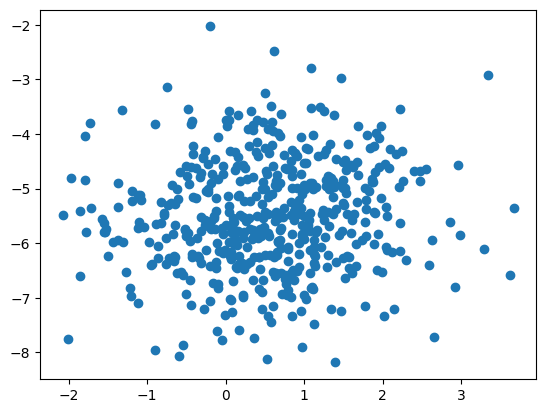

In [28]:
x_feats = [sample[0] for sample in X]
y_feats = [sample[1] for sample in X]

x_feats_centered = [sample[0] for sample in X_centered]
y_feats_centered = [sample[1] for sample in X_centered]

plt.scatter(x_feats, y_feats)
plt.show()

In [29]:
def custom_LODA(train_data, test_data, num_of_projection_vectors, num_of_histogram_bins):
  projection_vectors = []
  hists_list, bins_list, bins_probs = [], [], []

  for i in range(num_of_projection_vectors):
    p_vector = np.random.multivariate_normal(mean=(0, 0), cov=((1, 0), (0, 1)))
    p_vector = p_vector / np.linalg.norm(p_vector)

    projection_vectors.append(p_vector)

    scores = [[] for i in range(num_of_projection_vectors)]

  for i in range(num_of_projection_vectors):
    projected_X = np.dot(X, projection_vectors[i])
    projected_X_range = np.max(projected_X) - np.min(projected_X)

    hist, bins = np.histogram(projected_X, num_of_histogram_bins, range=(np.min(projected_X) - projected_X_range, np.max(projected_X) + projected_X_range))
    hists_list.append(hist)
    bins_list.append(bins)

    bin_prob = [bin_count / len(X) for bin_count in hist]
    bins_probs.append(bin_prob)

    bin_idxs = np.digitize(projected_X, bins)

    for idx in bin_idxs:
      scores[i].append(bin_prob[idx])

  scores = np.array(scores)
  scores = np.mean(scores, axis=0)

  test_scores = [[] for i in range(num_of_projection_vectors)]

  for i in range(num_of_projection_vectors):
    projected_test_X = np.dot(test_X, projection_vectors[i])

    bin_prob = bins_probs[i]
    bin_idxs = np.digitize(projected_test_X, bins_list[i])


    for idx in bin_idxs:
      test_scores[i].append(bin_prob[idx - 2])

  test_scores = np.array(test_scores)
  test_scores = np.mean(test_scores, axis=0)

  return scores, test_scores

In [30]:
test_X = [[np.random.uniform(-3, 3), np.random.uniform(-3, 3)] for i in range(500)]

x_feats_test = [sample[0] for sample in test_X]
y_feats_test = [sample[1] for sample in test_X]

In [31]:
scores, test_scores = custom_LODA(X, test_X, 5, 18)

[]

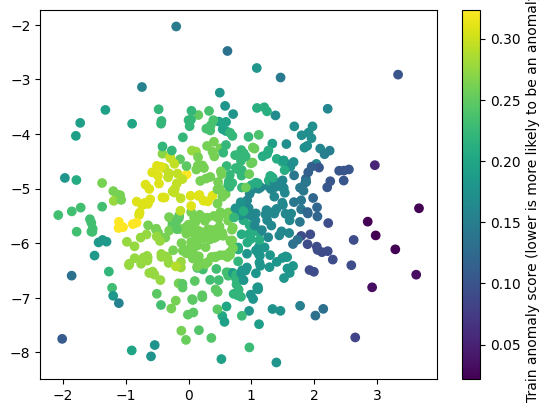

In [32]:
sc = plt.scatter(x_feats, y_feats, c=scores)

cbar = plt.colorbar(sc)
cbar.set_label('Train anomaly score (lower is more likely to be an anomaly)')
plt.plot()

[]

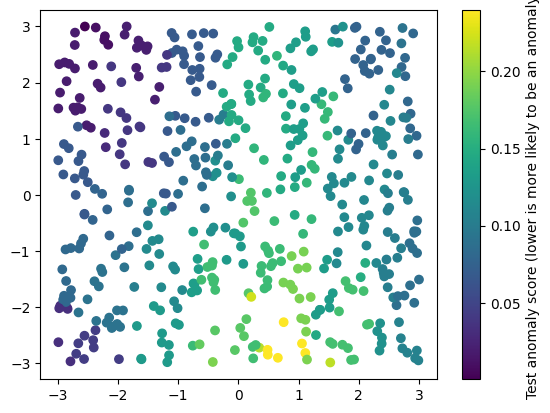

In [33]:
sc = plt.scatter(x_feats_test, y_feats_test, c=test_scores)

cbar = plt.colorbar(sc)
cbar.set_label('Test anomaly score (lower is more likely to be an anomaly)')
plt.plot()

[]

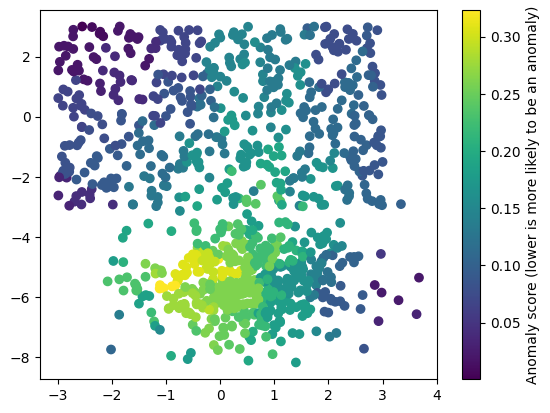

In [34]:
sc = plt.scatter(np.concatenate([x_feats, x_feats_test]), np.concatenate([y_feats, y_feats_test]), c=np.concatenate([scores, test_scores]))

cbar = plt.colorbar(sc)
cbar.set_label('Anomaly score (lower is more likely to be an anomaly)')
plt.plot()

In [36]:
# now training with train_data centered in (0, 0)

scores2, test_scores2 = custom_LODA(X_centered, test_X, 5, 18)

[]

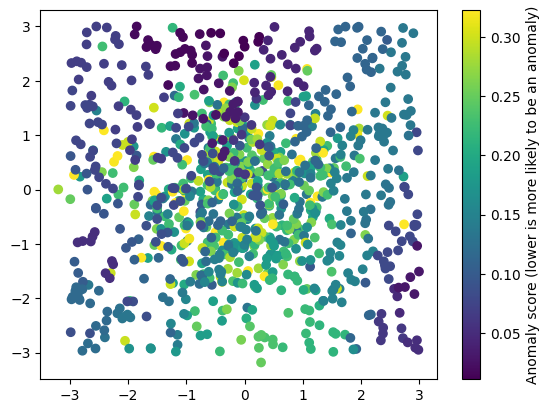

In [37]:
sc = plt.scatter(np.concatenate([x_feats_centered, x_feats_test]), np.concatenate([y_feats_centered, y_feats_test]), c=np.concatenate([scores2, test_scores2]))

cbar = plt.colorbar(sc)
cbar.set_label('Anomaly score (lower is more likely to be an anomaly)')
plt.plot()

In [38]:
# Exercise 2

X, y = make_blobs(n_samples=[500, 500], n_features=2, centers=[(10, 0), (0, 10)], cluster_std=[1, 1])
x_feats = [sample[0] for sample in X]
y_feats = [sample[1] for sample in X]

test_data = [[np.random.uniform(-10, 20), np.random.uniform(-10, 20)] for i in range(1000)]

x_feats_test = [sample[0] for sample in test_data]
y_feats_test = [sample[1] for sample in test_data]

In [39]:
model = IForest(contamination=0.02)

model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/pyod/models/base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


IForest(behaviour='old', bootstrap=False, contamination=0.02,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [40]:
preds, confs = model.predict(test_data, return_confidence=True)

In [41]:
scores = model.decision_function(test_data)

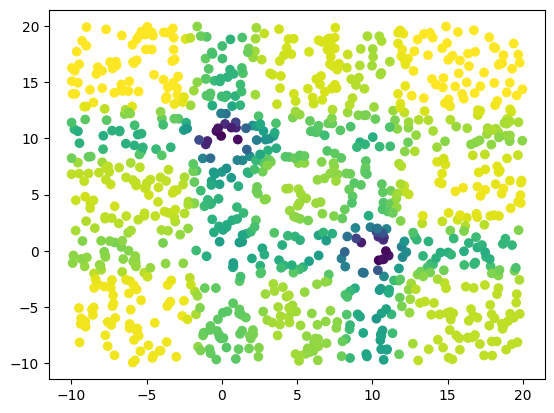

In [42]:
plt.scatter(x_feats_test, y_feats_test, c=scores)
plt.show()

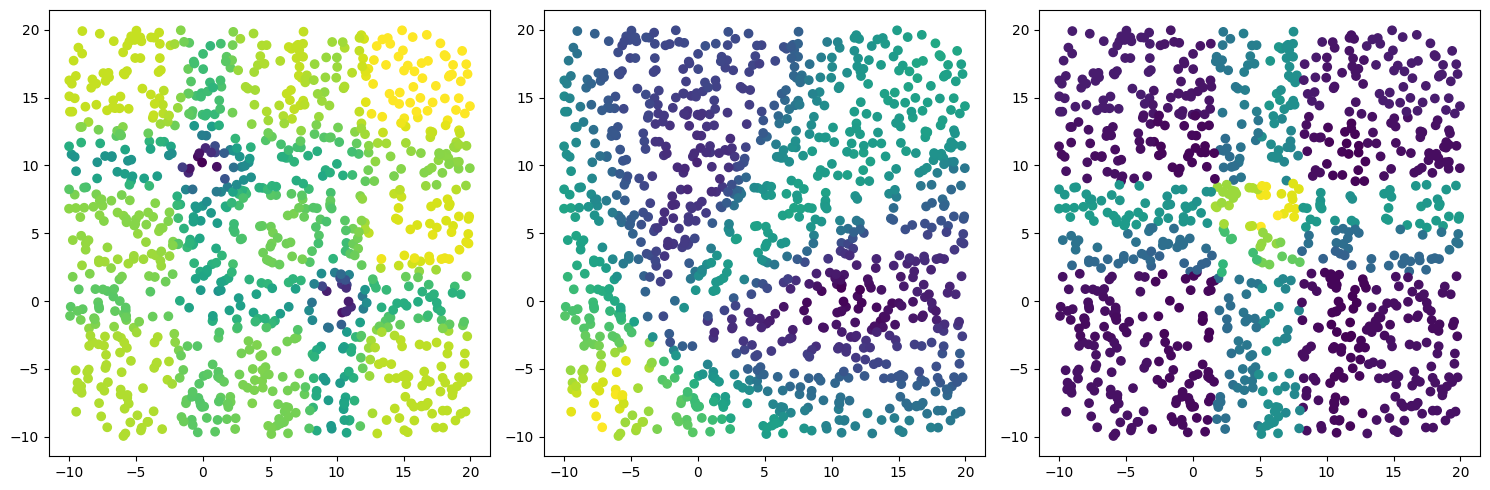

In [43]:
models = [IForest(contamination=0.02), DIF(contamination=0.02), LODA(contamination=0.02)]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, model in enumerate(models):
  model = model.fit(X)
  scores = model.decision_function(test_data)

  ax[i].scatter(x_feats_test, y_feats_test, c=scores)

plt.tight_layout()
plt.show()


In [44]:
# 3d case

X, y = make_blobs(n_samples=[500, 500], n_features=3, centers=[(0, 10, 0), (10, 0, 10)], cluster_std=[1, 1])
x_feats = [sample[0] for sample in X]
y_feats = [sample[1] for sample in X]
z_feats = [sample[2] for sample in X]

test_data = [[np.random.uniform(-10, 20), np.random.uniform(-10, 20), np.random.uniform(-10, 20)] for i in range(1000)]

x_feats_test = [sample[0] for sample in test_data]
y_feats_test = [sample[1] for sample in test_data]
Z_feats_test = [sample[2] for sample in test_data]

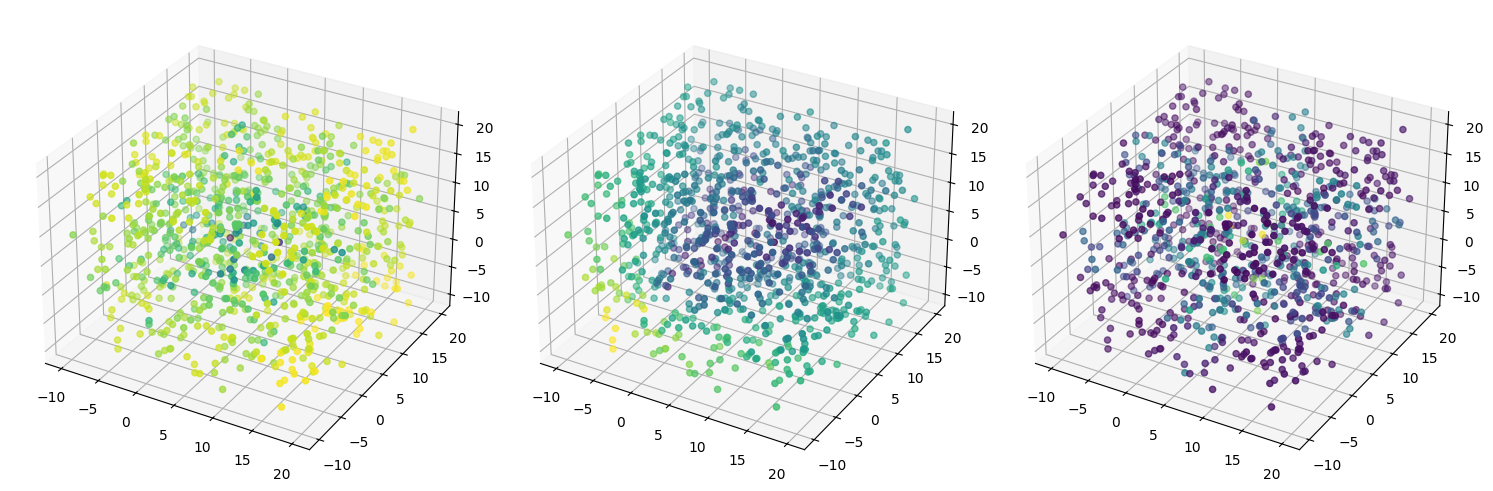

In [45]:
models = [IForest(contamination=0.02), DIF(contamination=0.02), LODA(contamination=0.02)]

fig = plt.figure(figsize=(15, 5))
fig_idx = [131, 132, 133]

for i, model in enumerate(models):
  model = model.fit(X)
  scores = model.decision_function(test_data)

  ax = fig.add_subplot(fig_idx[i], projection='3d')
  ax.scatter(x_feats_test, y_feats_test, Z_feats_test, c=scores)

plt.tight_layout()
plt.show()

In [47]:
# Exercise 3

# dataset link was broken, so I found it in some other place and saved it to a drive

!gdown 1fGzmCECogaS5FY1awCh8md2Q6rZn4rK3

Downloading...
From: https://drive.google.com/uc?id=1fGzmCECogaS5FY1awCh8md2Q6rZn4rK3
To: /content/shuttle_dataset.arff
100% 171k/171k [00:00<00:00, 84.3MB/s]


In [71]:
arff_file = arff.loadarff('/content/shuttle_dataset.arff')

shuttle_df = pd.DataFrame(arff_file[0])

In [73]:
print(shuttle_df.head())

       att1      att2      att3  att4      att5      att6      att7      att8  \
0  0.177215  0.296576  0.076923  0.24  0.614035  0.180233  0.433735  0.242718   
1  0.063291  0.296576  0.076923  0.24  0.614035  0.180233  0.530120  0.242718   
2  0.164557  0.296576  0.076923  0.24  0.175439  0.180233  0.445783  0.757282   
3  0.063291  0.296418  0.076923  0.24  0.614035  0.180233  0.542169  0.242718   
4  0.151899  0.297832  0.076923  0.24  0.175439  0.180233  0.457831  0.757282   

       att9  outlier  
0  0.180328        1  
1  0.114754        1  
2  0.606557        1  
3  0.114754        1  
4  0.590164        1  


In [72]:
shuttle_df.drop(columns=['id'], inplace=True)

shuttle_df['outlier'] = shuttle_df['outlier'].str.decode('utf-8')
shuttle_df['outlier'] = shuttle_df['outlier'].map({'yes': 1, 'no': 0})

In [ ]:
train_df, test_df = train_test_split(shuttle_df, test_size=0.4)

X_train = train_df.drop(columns=['outlier']).values
Y_train = train_df['outlier'].values

X_test = test_df.drop(columns=['outlier']).values
Y_test = test_df['outlier'].values

IForest Balanced Accuracy: 0.4875
IForest ROC AUC: 0.7391666666666666

DIF Balanced Accuracy: 0.5
DIF ROC AUC: 0.6166666666666667

LODA Balanced Accuracy: 0.48625
LODA ROC AUC: 0.36875



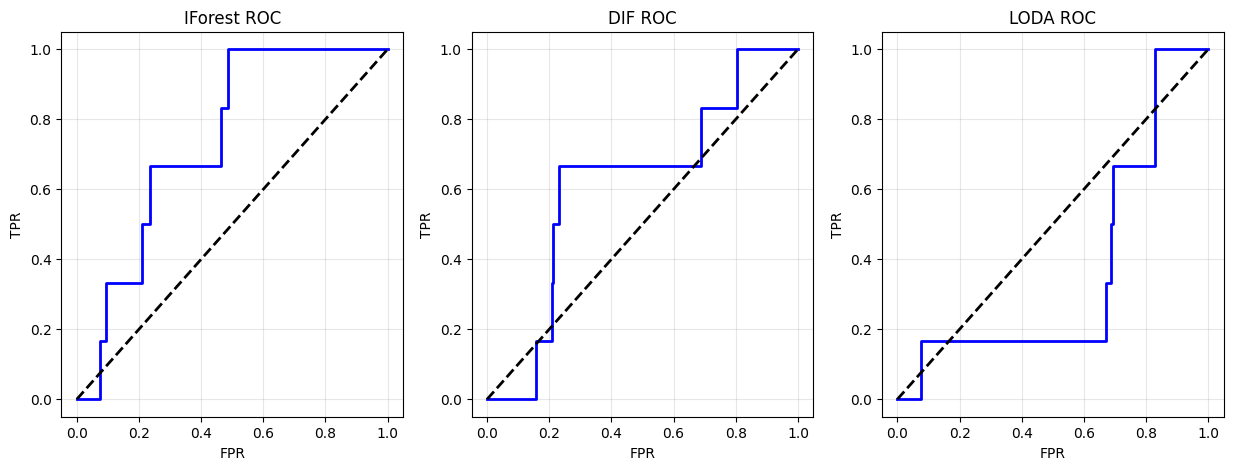

In [96]:
models = [IForest(contamination=0.02), DIF(contamination=0.02), LODA(contamination=0.02)]
models_names = ['IForest', 'DIF', 'LODA']

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, model in enumerate(models):
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_scores = model.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(Y_test, y_scores)

    ba = balanced_accuracy_score(Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_scores)

    print(f'{models_names[i]} Balanced Accuracy:', ba)
    print(f'{models_names[i]} ROC AUC:', roc_auc)
    print()

    ax[i].plot(fpr, tpr, color='blue', lw=2)
    ax[i].plot([0, 1], [0, 1], 'k--', lw=2)
    ax[i].set_xlabel("FPR")
    ax[i].set_ylabel("TPR")
    ax[i].set_title(f"{models_names[i]} ROC")
    ax[i].grid(alpha=0.3)

plt.show()